# Covid - 19 Forecasting

![Covid - 19](https://eyewire.news/wp-content/uploads/sites/2/2020/03/banner.png)

This notebook contains the Implementation of a standard LSTM to forecast the covid - 19 (Confirmed Cases) using the time series data

## Steps Involved
- Libraries
- Dataset Pre-Processing
- Neural Netowork Architecture Design
- Training the Model
- Forecasting
- Conclusion
- Drawbacks

## Libraries

Importing all the required modules

In [1]:
#importing the libraries
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

## Dataset Pre-Processing

Dataset contains a lot of Information. removing unwanted columns , negating the effects of cummulative summation and processing the data so as for the neural network to accept are done in this module

In [2]:
# importing the dataset
df = pd.read_csv("./day_wise.csv")
df.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


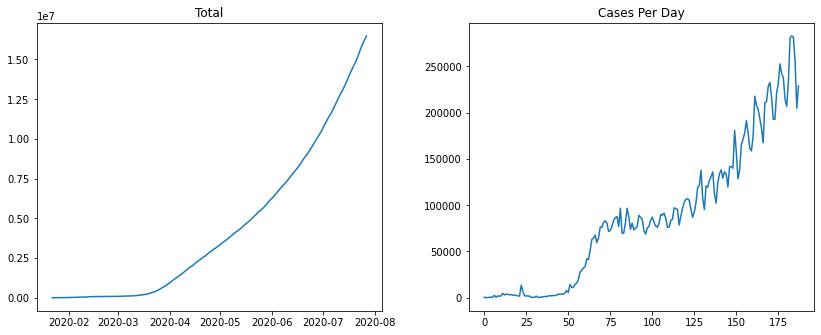

In [3]:
# data pre-processing
df = df.iloc[:,0:2]
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
df.set_index("Date",inplace=True)

# date pre-processing for neural network
confirmed = np.array(df['Confirmed'])

# per day
for i in range(confirmed.shape[0]-1,0,-1):
  confirmed[i] -= confirmed[i-1]


# visualize the count per day
fig = plt.figure(figsize=(12,4))

# total plot
ax1 = fig.add_axes([0,0,0.4,1])
ax1.plot(df['Confirmed'],label='(Cummulative)')
plt.title("Total")

# per day plot
ax2 = fig.add_axes([0.5,0,0.4,1])
ax2.plot(confirmed,label='Cases Per Day')
plt.title("Cases Per Day")
plt.show()

# model data pre-processing
X = []
Y = []
for i in range(confirmed.shape[0] - 10):
  lis = []
  for j in range(i,i+10):
    lis.append(confirmed[j])
  X.append(lis)
  Y.append(confirmed[i+10])

X = np.array(X).reshape(-1,10)
Y = np.array(Y).reshape(-1,1)

# scaling inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
pred_scaler = MinMaxScaler()
X = scaler.fit_transform(X)
Y = pred_scaler.fit_transform(Y)

# converting to tensors
X = torch.tensor(X,dtype=torch.float32).reshape(-1,10,1)
Y = torch.tensor(Y,dtype=torch.float32).reshape(-1,1)

## Neural Network Architecture Design

This module contains the neural network's architecural design *(Type of the network and layers, number of layers and number of units per layere,etc...)*

In [4]:
# Neural Network

# Network Config
input_size = 1
hidden_size=20
num_layers=1

# Neural Network
class net(nn.Module):
  def __init__(self):
    super(net,self).__init__()
    self.l1 = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
    self.l2 = nn.Linear(in_features=hidden_size,out_features=10)
    self.l3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    x,_ = self.l1(x)
    x = self.l2(torch.relu(x[:,-1]))
    x = self.l3(torch.relu(x))
    return x

# Model Object
model = net()

# Model Config
optimizer = torch.optim.SGD(model.parameters(),lr=0.05)
epochs = 3000
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,verbose=True)

## Training the Model

The randomly initialized weights of the neural network model is trained via gradient descent so as to reduce loss

In [5]:
# Forward Pass
costs = []
for i in range(epochs):
  
  # Making Predictions
  y_pred = model(X)

  # Calculating Loss
  cost = criterion(y_pred,Y)
  costs.append(cost)

  # Gradient Descent
  optimizer.zero_grad()
  cost.backward()
  scheduler.step(cost)
  optimizer.step() 

  if i%300 == 0:
    print(cost)

tensor(0.3347, grad_fn=<MseLossBackward>)
tensor(0.0524, grad_fn=<MseLossBackward>)
tensor(0.0042, grad_fn=<MseLossBackward>)
tensor(0.0026, grad_fn=<MseLossBackward>)
tensor(0.0025, grad_fn=<MseLossBackward>)
tensor(0.0025, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)


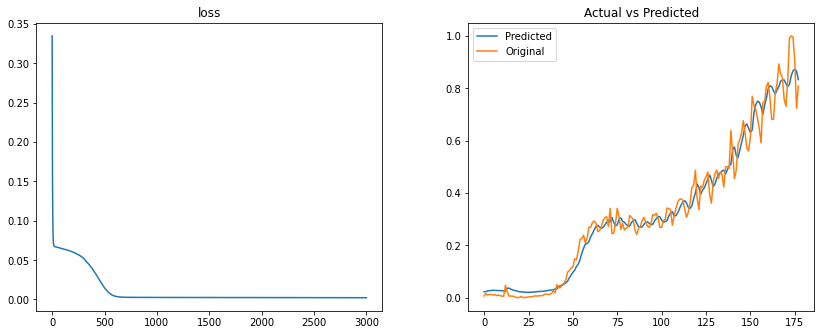

In [6]:
# visualizing the predictions
fig = plt.figure(figsize=(12,4))

# Loss plot
ax1 = fig.add_axes([0,0,0.4,1])
ax1.plot(costs,label='loss')
plt.title("loss")

# Actual vs Predicted Plot
ax2 = fig.add_axes([0.5,0,0.4,1])
ax2.plot(model(X).detach(),label='Predicted')
ax2.plot(Y.detach(),label='Original')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

## Forecasting

using the trained model, predictions can be made for the next 50 days with a significant amount of data formatting

50th day from now would have   232917.0  cases per that day


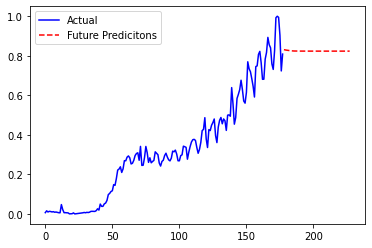

In [7]:
# forecasting

# amount of days to predict in the future
forward_time = 50

# prediction loop
for i in range(forward_time):
  y_pred = model(X[-1].reshape(-1,10,1))
  copy_X = X.numpy().reshape(-1,10)
  new_row = copy_X[-1]
  new_row = np.roll(new_row,-1)
  new_row[-1] = y_pred.item()
  copy_X = np.append(copy_X,new_row).reshape(-1,10)
  X = torch.tensor(copy_X.reshape(-1,10,1),dtype=torch.float32)

# visualize the prediction
y_pred = model(X).detach().numpy()
plt.plot(np.arange(y_pred.shape[0]-forward_time),Y.detach().numpy().reshape(-1),color='blue',label='Actual')
plt.plot(np.arange(y_pred.shape[0]-forward_time,y_pred.shape[0]),y_pred.reshape(-1)[-forward_time:],color='red',linestyle='--',label='Future Predicitons')
plt.legend()

# predicitions for the last 50 days
final_50 = pred_scaler.inverse_transform(y_pred.reshape(-1,1)[-50:])
print("50th day from now would have  ",final_50[-1][0].round()," cases per that day")

## Conclusion

- So, Model has predicted that the 50th day will have 232917 new cases.
- The further the future we are trying to predict , lesser accurate the prediction becomes
- The next few days will not have much variance in terms of number of cases

## Disadvantages

- Very Less amount of data.( only had about 188 rows, wheras deep learning requires tons and tons of data ). The model couldn't generealize well due to the extremely low amount of data

- Due to less data, unable to use validation set for further tuning of the model.
- Due to real world entities, the data may be somewhat instable